LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [21]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic    #Requires MOSEK >= 10.2

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [22]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [23]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [24]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [25]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data(read_volume=True)
df_prices, df_volumes = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameter `a` is the coefficient vector in the market impact cost term, the parameter `beta` is used in the exponent in the market impact formula, and `rf` is the risk free interest rate.

In [26]:
def EfficientFrontier(N, m, G, deltas, a, beta, rf):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Variable for risk-free asset (cash account)
        xf = M.variable("xf", 1, Domain.greaterThan(0.0))        
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Auxiliary variable to model market impact 
        t = M.variable("t", N, Domain.unbounded())

        # Budget constraint with transaction cost terms
        M.constraint('budget', Expr.sum(x) + xf + t.T @ a == 1.0)
        
        # Power cone to model market impact 
        M.constraint('market_impact', Expr.hstack(t, Expr.constTerm(N, 1.0), x), Domain.inPPowerCone(1.0 / beta))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, x.T @ m + rf * xf - delta * s )
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, G.T @ x), Domain.inRotatedQCone())
    
        columns = ["delta", "obj", "return", "risk", "t_resid", "x_sum", "xf", "tcost"] + df_prices.columns.tolist()
        
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Check if the solution is an optimal point
            solsta = M.getPrimalSolutionStatus()
            if (solsta != SolutionStatus.Optimal):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!") 
            
            # Save results
            portfolio_return = m @ x.level() + np.array([rf]) @ xf.level()
            portfolio_risk = np.sqrt(2 * s.level()[0]) 
            risky_return = m @ x.level()
            t_resid = t.level() - np.abs(x.level())**beta
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, 
                             sum(t_resid), sum(x.level()), sum(xf.level()), t.level() @ a] + list(x.level()), index=columns)
     
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [27]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [28]:
G = np.linalg.cholesky(S)  

We also compute the average daily volume and daily volatility (std. dev.)

In [29]:
df_lin_returns = df_prices.pct_change()
volatility = df_lin_returns.std()
volume = (df_volumes * df_prices).mean()

Finally we specify the parameters of market impact, risk free rate, and portfolio size.

In [30]:
# Market impact coefficient
beta = 3 / 2
c = 1
rf = 0.01
portfolio_value = 10**10

# Compute portfolio relative volume , because the variable x is also portfolio relative.
rel_volume = volume / portfolio_value

# a1 means no impact, a2 means impact
a1 = np.zeros(N)
a2 = (c * volatility / rel_volume**(beta - 1)).to_numpy()

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute and plot the efficient frontier this way both with and without market impact cost. 

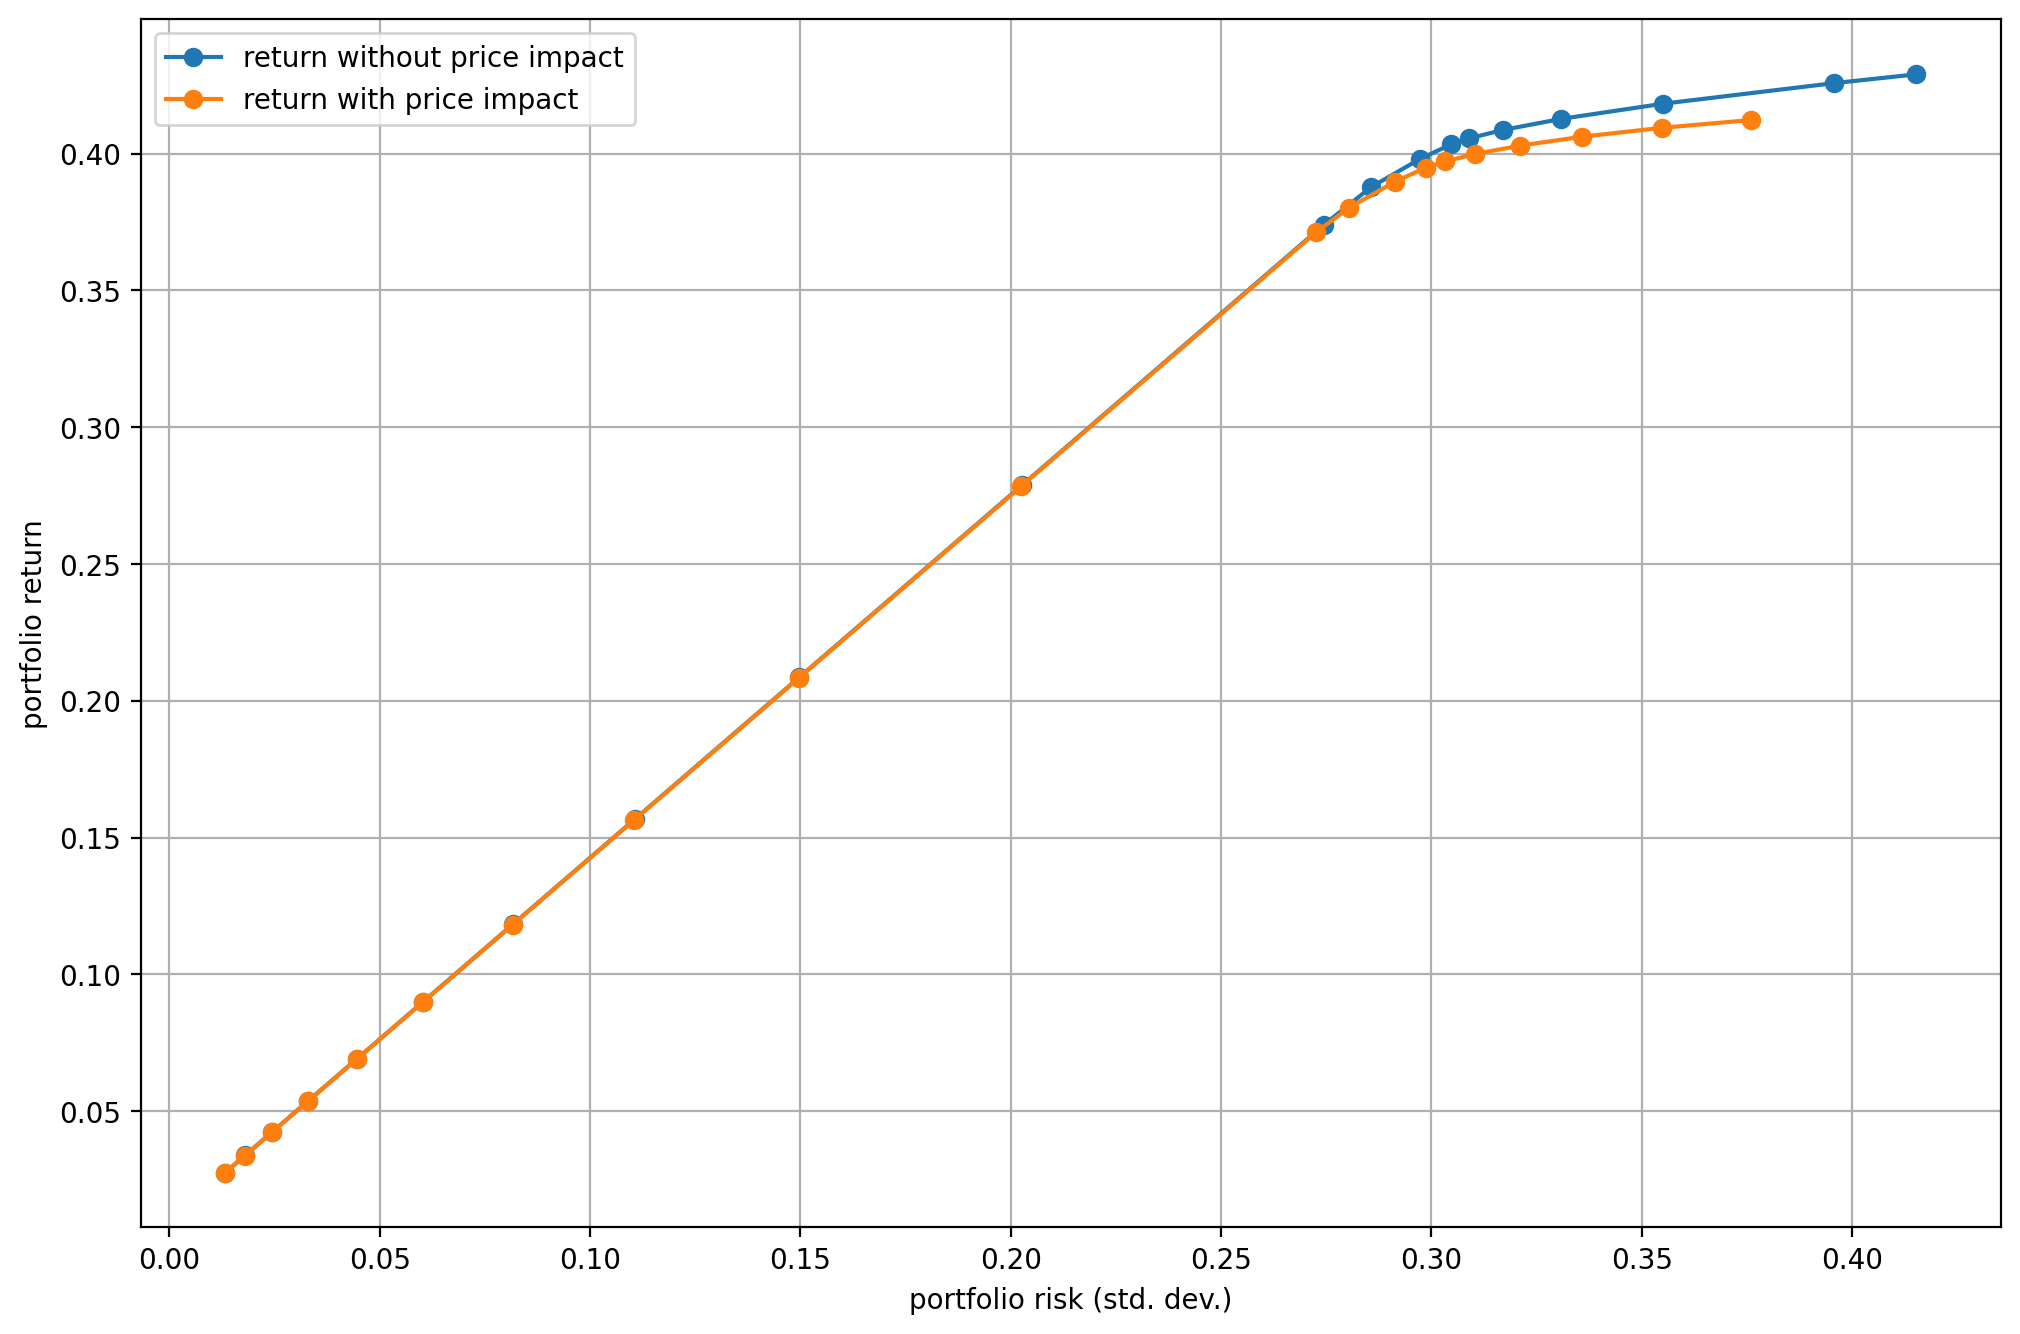

In [31]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]

ax = plt.gca()
for a in [a1, a2]:
    df_result = EfficientFrontier(N, m, G, deltas, a, beta, rf)
    df_result.plot(ax=ax, x="risk", y="return", style="-o", 
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without price impact", "return with price impact"])

In [32]:
df_result

,delta,obj,return,risk,t_resid,x_sum,xf,tcost,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,0.018790,0.027579,0.013258,1.409437e-06,0.047430,9.523007e-01,0.000270,7.384062e-10,3.492337e-09,1.560750e-08,9.255996e-10,0.005845,0.030481,1.110292e-02,2.005896e-09
1,73.861998,0.021900,0.033798,0.017949,8.868563e-07,0.064211,9.353648e-01,0.000425,4.115499e-10,1.694335e-09,7.233661e-09,5.168015e-10,0.007915,0.041267,1.502848e-02,1.036294e-09
2,54.555948,0.026111,0.042218,0.024300,2.066310e-06,0.086929,9.124021e-01,0.000669,9.675016e-10,7.633847e-09,4.879841e-08,1.297328e-09,0.010719,0.055868,2.034184e-02,3.466895e-09
3,40.296113,0.031810,0.053615,0.032897,4.129274e-06,0.117684,8.812629e-01,0.001053,1.669839e-09,9.676767e-09,6.182178e-08,2.131469e-09,0.014515,0.075637,2.753150e-02,5.142045e-09
4,29.763514,0.039526,0.069044,0.044536,5.611713e-07,0.159317,8.390245e-01,0.001659,2.639029e-10,1.555416e-09,7.700856e-09,3.397585e-10,0.019658,0.102398,3.726174e-02,8.681476e-10
5,21.983926,0.049971,0.089929,0.060293,1.525075e-06,0.215676,7.817115e-01,0.002612,6.768740e-10,3.982106e-09,1.937252e-08,8.770383e-10,0.026622,0.138627,5.042681e-02,2.267352e-09
6,16.237767,0.064110,0.118199,0.081622,8.943029e-07,0.291968,7.039184e-01,0.004114,4.653877e-10,2.333089e-09,1.235061e-08,5.979785e-10,0.036056,0.187675,6.823738e-02,1.386821e-09
7,11.993539,0.083249,0.156465,0.110496,1.668722e-06,0.395242,5.982799e-01,0.006478,7.340574e-10,4.225165e-09,2.160286e-08,9.562667e-10,0.048836,0.254072,9.233388e-02,2.417856e-09
8,8.858668,0.109156,0.208260,0.149581,3.317164e-06,0.535034,4.547640e-01,0.010201,1.031830e-09,6.343991e-09,3.181106e-08,1.335507e-09,0.066151,0.343956,1.249278e-01,3.566057e-09
9,6.543189,0.144222,0.278363,0.202489,9.939790e-07,0.724252,2.596848e-01,0.016063,3.768487e-10,1.650911e-09,5.697224e-09,4.980522e-10,0.089609,0.465635,1.690072e-01,1.182601e-09
